# RESEARCH PROJECT: Augmentation and classification of Blood cell images using GAN’s


# Abstract
The malaria virus doesn’t take the form of a mutant mosquito, it sure feels like a mutant problem. The deadly disease has reached epidemic, even endemic proportions in different parts of the world — killing around 400,000 people annually.We are using NIH that has a malaria dataset of 27,558 cell images with an equal number of parasitized and uninfected cells. The algorithms on which we will be working on are: training CNNs to classify images of malaria infected blood cells and trying to create different models.Then, we will compare the CNN models and then the best model will be used for ResNet Network. Next step will be generating medical images of malaria infected blood cells using Generative Adversarial Networks. (GANs) and then we will compare and test the generated images with original images.The best CNN model gave an accuracy of 55.48% and this model was used for ResNet network. The CNN model with ResNet network gave an accuracy of almost 95% and is used for testing the gengered images.



# Dataset
We are using a great dataset of labeled and preprocessed images to train and evaluate our model. NIH has a malaria dataset of 27,558 cell images with an equal number of parasitized and uninfected cells. A level-set based algorithm was applied to detect and segment the red blood cells. The images were collected and annotated by medical professionals; more information can be found here.

https://ceb.nlm.nih.gov/repositories/malaria-datasets/

In [0]:
!wget https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip

--2019-04-22 15:47:04--  https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip
Resolving ceb.nlm.nih.gov (ceb.nlm.nih.gov)... 130.14.52.15, 2607:f220:41e:7052::15
Connecting to ceb.nlm.nih.gov (ceb.nlm.nih.gov)|130.14.52.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353452851 (337M) [application/zip]
Saving to: ‘cell_images.zip’

cell_images.zip     100%[===================>] 337.08M  41.0MB/s    in 8.7s    

2019-04-22 15:47:13 (38.9 MB/s) - ‘cell_images.zip’ saved [353452851/353452851]



In [0]:
import zipfile
path_to_zip_file = "cell_images.zip"
zip_ref = zipfile.ZipFile(path_to_zip_file, 'r')
zip_ref.extractall()

# Importing Libraries

In [0]:
from keras.layers import Input, Reshape, Dropout, Dense, MaxPooling2D, Flatten, BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model, load_model
import tensorflow as tf
from keras.optimizers import Adam
from PIL import Image
import numpy as np
from keras.optimizers import SGD
from tqdm import tqdm

Using TensorFlow backend.


In [0]:
import os
import random
import matplotlib.pyplot as plt
input_directory = "cell_images"
output_directory = r"../output/"

training_dir = input_directory
# testing_dir = input_directory + r"test"

if not os.path.exists(output_directory):
    os.mkdir(output_directory)
    
figure_directory = "../output/figures"
if not os.path.exists(figure_directory):
    os.mkdir(figure_directory)
    
    
file_name_pred_batch = figure_directory+r"/result"
file_name_pred_sample = figure_directory+r"/sample"

In [0]:
!rm cell_images/Parasitized/Thumbs.db

# Plotting images of Parasitized & Uninfected cells


In [0]:
def plot_image(file, directory=None, sub=False, aspect=None):
    path = directory + file
    
    img = plt.imread(path)
    
    plt.imshow(img, aspect=aspect)
#     plt.title(file)
    plt.xticks([])
    plt.yticks([])
    
    if sub:
        plt.show()
        
def plot_img_dir(directory=training_dir, count=5):
    selected_files = random.sample(os.listdir(directory), count)
    
    ncols = 5
    nrows = count//ncols if count%ncols==0 else count//ncols+1
    
    figsize=(20, ncols*nrows)

    ticksize = 14
    titlesize = ticksize + 8
    labelsize = ticksize + 5


    params = {'figure.figsize' : figsize,
              'axes.labelsize' : labelsize,
              'axes.titlesize' : titlesize,
              'xtick.labelsize': ticksize,
              'ytick.labelsize': ticksize}

    plt.rcParams.update(params)
    
    i=0
    
    for file in selected_files:        
        plt.subplot(nrows, ncols, i+1)
        path = directory + file
        plot_image(file, directory, aspect=None)

        i=i+1
    
    plt.tight_layout()
    plt.show()
    
def plot_img_dir_main(directory=training_dir, count=5):
    labels = os.listdir(directory)
    for label in labels:
        print(label)
        plot_img_dir(directory=directory+"/"+label+"/", count=count)

# Images of Parasitized and Uninfected Images

Parasitized


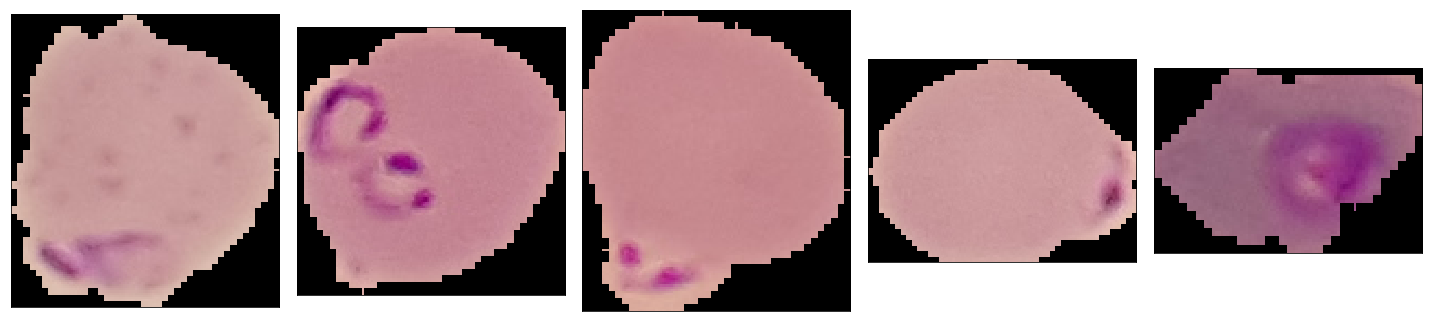

Uninfected


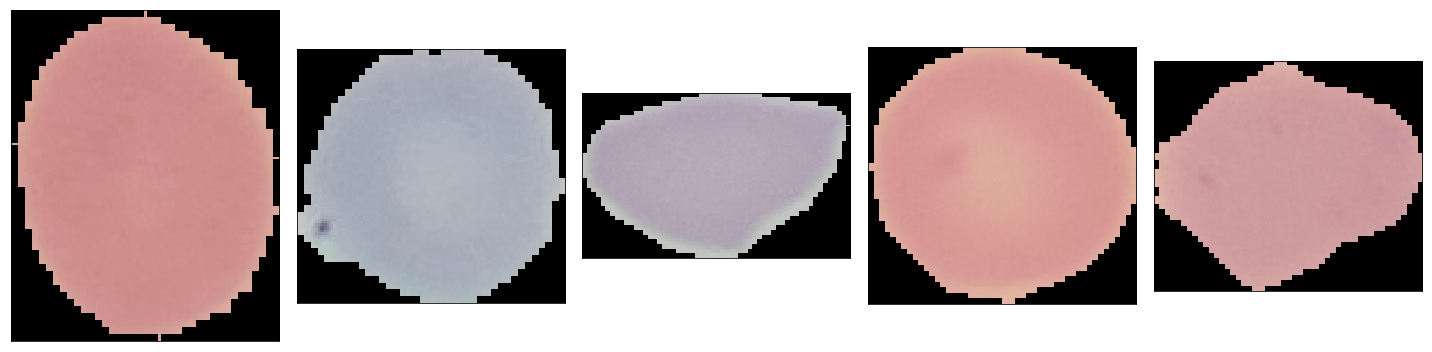

In [0]:
plot_img_dir_main(directory=training_dir, count=5)

In [0]:
import os

# initialize the path to the original input directory of images
orig_input_dataset = "cell_images"

# initialize the base path to the new directory that will contain
# our images after computing the training and testing split
base_path = "output"

# derive the training, validation, and testing directories
train_path = os.path.sep.join([base_path, "training"])
val_path = os.path.sep.join([base_path, "validation"])
test_path = os.path.sep.join([base_path, "testing"])
 
# define the amount of data that will be used for training
train_split = 0.8
 
# the amount of validation data will be a percentage of the
# training data
val_split = 0.1

# Importing Imutils
A series of convenience functions to make basic image processing functions such as translation, rotation, resizing, skeletonization, displaying Matplotlib images, sorting contours, detecting edges, and much more easier with OpenCV



In [0]:
from imutils import paths # which you need to download! 
import random
import shutil
import os

# shuffle all the images in the original input directory 
imagePaths = list(paths.list_images(orig_input_dataset))
random.seed(42)
random.shuffle(imagePaths)

# Splitting the data into testing and training

In [0]:
i = int(len(imagePaths) * train_split)
trainPaths = imagePaths[:i]
testPaths = imagePaths[i:]

# set aside some of the training data for validation data 
i = int(len(trainPaths) * val_split)
valPaths = trainPaths[:i]
trainPaths = trainPaths[i:]

# define the training/validation/testing datasets 
datasets = [
	("training", trainPaths, train_path),
	("validation", valPaths, val_path),
	("testing", testPaths, test_path)
]

In [0]:
# loop over the datasets
for (dType, imagePaths, baseOutput) in datasets:
	# show which data split we are creating
	print("[INFO] building '{}' split".format(dType))
 
	# if the output base output directory does not exist, create it
	if not os.path.exists(baseOutput):
		print("[INFO] 'creating {}' directory".format(baseOutput))
		os.makedirs(baseOutput)
 
	# loop over the input image paths
	for inputPath in imagePaths:
		# extract the filename of the input image along with its
		# corresponding class label
		filename = inputPath.split(os.path.sep)[-1]
		label = inputPath.split(os.path.sep)[-2]
 
		# build the path to the label directory
		labelPath = os.path.sep.join([baseOutput, label])
 
		# if the label output directory does not exist, create it
		if not os.path.exists(labelPath):
			print("[INFO] 'creating {}' directory".format(labelPath))
			os.makedirs(labelPath)
 
		# construct the path to the destination image and then copy
		# the image itself
		p = os.path.sep.join([labelPath, filename])
		shutil.copy2(inputPath, p)

[INFO] building 'training' split
[INFO] 'creating output/training' directory
[INFO] 'creating output/training/Parasitized' directory
[INFO] 'creating output/training/Uninfected' directory
[INFO] building 'validation' split
[INFO] 'creating output/validation' directory
[INFO] 'creating output/validation/Parasitized' directory
[INFO] 'creating output/validation/Uninfected' directory
[INFO] building 'testing' split
[INFO] 'creating output/testing' directory
[INFO] 'creating output/testing/Parasitized' directory
[INFO] 'creating output/testing/Uninfected' directory


# Determining the number of image paths in training/validation/testing directories

In [0]:
totalTrain = len(list(paths.list_images(train_path)))
totalVal = len(list(paths.list_images(val_path)))
totalTest = len(list(paths.list_images(test_path)))

# Data Augmentation

* Applying data augmentation to our images will help with regularization
* It will help mitigate overfitting
* Our network will generalize better to the validation data (which could mean performing worse on the training set).



In [0]:
from keras.preprocessing.image import ImageDataGenerator
# initialize the training training data augmentation object
trainAug = ImageDataGenerator(
	rescale=1 / 255.0,
	rotation_range=20,
	zoom_range=0.05,
	width_shift_range=0.05,
	height_shift_range=0.05,
	shear_range=0.05,
	horizontal_flip=True,
	fill_mode="nearest")
 
# initialize the validation (and testing) data augmentation object
valAug = ImageDataGenerator(rescale=1 / 255.0)

# Initializing the training, validation and testing generators

In [0]:
BS = 32
# initialize the training generator
trainGen = trainAug.flow_from_directory(
	train_path,
	class_mode="categorical",
	target_size=(64, 64),
	#color_mode="rgb",
	shuffle=True,
	batch_size=BS)

# initialize the validation generator
valGen = valAug.flow_from_directory(
	val_path,
	class_mode="categorical",
	target_size=(64, 64),
	color_mode="rgb",
	shuffle=False,
	batch_size=BS)

# initialize the testing generator
testGen = valAug.flow_from_directory(
	test_path,
	class_mode="categorical",
	target_size=(64, 64),
	color_mode="rgb",
	shuffle=False,
	batch_size=BS)

Found 19842 images belonging to 2 classes.
Found 2204 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.


# Convolutional Neural Network

Convolutional Neural Networks are very similar to ordinary Neural Networks from the previous chapter: they are made up of neurons that have learnable weights and biases. Each neuron receives some inputs, performs a dot product and optionally follows it with a non-linearity. The whole network still expresses a single differentiable score function: from the raw image pixels on one end to class scores at the other. And they still have a loss function (e.g. SVM/Softmax) on the last (fully-connected) layer and all the tips/tricks we developed for learning regular Neural Networks still apply.

![Image of CNN](https://cdn-images-1.medium.com/max/800/1*NQQiyYqJJj4PSYAeWvxutg.png)

# Model Parameters

* Dimensions of image for the custom CNN
* RGB
* Binary classification
* Modify based on the GPUs in your system
* Modify depending on the model convergence with your data

In [0]:
img_rows=64 #dimensions of image for the custom CNN
img_cols=64
channel = 3 #RGB
num_classes = 2 #binary classification
batch_size = 32 # modify based on the GPUs in your system
num_epoch = 30 # modify depending on the model convergence with your data

# Model architecture and Compling the Model

In [0]:
#model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3),padding='same', input_shape=(img_rows, img_cols, channel)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(num_classes, activation='sigmoid'))
model.summary()

#fix the optimizer
sgd = SGD(lr=1e-6, decay=1e-6, momentum=0.9, nesterov=True) #try varying this for your task and see the best fit

#compile the model
model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxP

# Fitting the Model

In [0]:
H = model.fit_generator(
	trainGen,
	steps_per_epoch=totalTrain // BS,
	validation_data=valGen,
	validation_steps=totalVal // BS,
	epochs=num_epoch)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
620/620 [==============================] - 66s 107ms/step - loss: 0.6943 - acc: 0.4922 - val_loss: 0.6929 - val_acc: 0.5179
Epoch 2/30
620/620 [==============================] - 61s 98ms/step - loss: 0.6944 - acc: 0.4963 - val_loss: 0.6929 - val_acc: 0.5170
Epoch 3/30
620/620 [==============================] - 60s 96ms/step - loss: 0.6944 - acc: 0.4965 - val_loss: 0.6929 - val_acc: 0.5189
Epoch 4/30
620/620 [==============================] - 60s 96ms/step - loss: 0.6938 - acc: 0.5026 - val_loss: 0.6929 - val_acc: 0.5189
Epoch 5/30
620/620 [==============================] - 58s 93ms/step - loss: 0.6939 - acc: 0.5035 - val_loss: 0.6929 - val_acc: 0.5184
Epoch 6/30
620/620 [==============================] - 60s 96ms/step - loss: 0.6932 - acc: 0.5037 - val_loss: 0.6928 - val_acc: 0.5207
Epoch 7/30
620/620 [==============================] - 60s 96ms/step - loss: 0.6938 - acc: 0.5021 - val_loss: 0.6929 - val_acc: 0.5180
Epoch 8/30
62

<table style="text-align:left"> 
    <thead> 
    <tr> <th>Number</th> <th>Model Name</th> <th>Accuray</th> </tr> </thead> <tbody> 
    <tr> 
         <th scope='row'>1</th> <td style="text-align:center">CNN Model 1 </td> <td>0.5221</td> </tr> 
        <tr> <th scope='row'>2</th> <td style="text-align:center">CNN Model 2</td>  <td>0.5331</td> </tr>
        <tr> <th scope='row'>3</th> <td style="text-align:center">CNN Model 3</td>  <td>0.5200</td> </tr>
 

# Conclusion
The Malaria Detection dataset using convolutional neural network gave an accuracy of 55.48% for 30 epochs. This was the base model in which the parameters used were:

* Activation Function: Rectified linear unit (ReLU)
* Cost function: categorical_crossentropy
* No.of Epochs: 30
* Gradient estimation: Stochastic Gradient Descent

We ran it for 30 epochs and got almost 52.21% accuracy. It can surely go much further since it was still undertrained! To improve the model the learning rate should be improved. Also, number of neurons can be more complicated for a better fit.Along, with that all, the parameters mentioned above can also be changed in order to improve the model accuracy.

The CNN model was then built on ResNet network which consisted of:

* Stages = (3, 4, 6)
* Filters = (64, 128, 256, 512) 
The model gave an accuracy of around 95% with only 4 epochs. This shows that the model has trained well and gave a very good accuracy with less number of epochs. It will be further used for the testing of GAN's.On those basis we can decide how correctly the network performs in classifying the images of Malaria Dataset cells.

# Contributions
Our personal contributions were around 65%, and we used 30% of the external references. We performed the following:

* Created the CNN models by using the malaria detection dataset
* Tuned the CNN model network architecture to achieve better accuracy for testing the data
* Compared the CNN models and selected the best model for ResNet network
* Used the best CNN model for implementation of ResNet network
* Generated medical images of malaria infected blood cells using CNN models 
* Reviewed a broad overview of recent literature on CNNs for medical applications along with the shortcomings and opportunities of the proposed methods

# License 
### LICENSES:

*The MIT license:*

https://opensource.org/licenses/MIT  Copyright 2019 Rajeshree Kale, Vignesh Murali, Rishi Raj Rajani

*The Creative Commons Attribution 3.0 License:*

<a rel="license" href="http://creativecommons.org/licenses/by/3.0/us/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/3.0/us/80x15.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/3.0/us/">Creative Commons Attribution 3.0 United States License</a>.


# References
Convolutional Neural Network : https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

Data Augmentation for CNNs: https://ieeexplore.ieee.org/document/8388338/

Resnet https://towardsdatascience.com/implementing-a-resnet-model-from-scratch-971be7193718

GANs: https://www.datacamp.com/community/tutorials/generative-adversarial-networks

GANs using Keras: https://towardsdatascience.com/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0